# Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.manifold import TSNE
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


## Methods to calculate the size of images before and after compression
The function array_size_mb calculates the size of a numpy array in megabytes. It converts the size from bytes to kilobytes, and then to megabytes.

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

def array_size_mb(arr):
    # Number of bytes
    total_bytes = arr.nbytes
    # Size in kilobytes (KB)
    size_in_kb = total_bytes / 1024
    # Size in megabytes (MB)
    size_in_mb = size_in_kb / 1024
    return size_in_mb


## Prepare the MNIST dataset

This section sets up the MNIST dataset for training and testing. The train_dataset and test_dataset variables download the MNIST dataset, applying the transformations. The train_loader and test_loader variables create data loaders for iterating over the training and test datasets.

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

## Define the AutoEncoder model
This section defines the Autoencoder model using PyTorch. The model consists of an encoder, fully connected layers (bottleneck), and a decoder. The encoder compresses the input image into a latent representation, while the decoder reconstructs the image from this representation.

![Example Image](img/auto-encoder.png)


In [4]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        
        # Fully connected layers to create the bottleneck
        self.fc1 = nn.Linear(392, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 392)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.fc2(x)
        x = x.view(x.size(0), 8, 7, 7)  # Reshape
        x = self.decoder(x)
        return x

## Train the model

In [5]:
def train_model(compression_ratio = 0.95):
    latent_dim = int(28 * 28 * (1 - compression_ratio))
    model = Autoencoder(latent_dim=latent_dim).to(device) 
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Compile and Train the Model
    num_epochs = 5
    for epoch in range(num_epochs):
        losses= []
        for data in tqdm(train_loader):
            img, _ = data
            img = img.to(device)
            # Forward pass
            output = model(img)
            loss = criterion(output, img)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    avg_loss = sum(losses) / len(losses)
    return model, avg_loss

model, _ = train_model(compression_ratio=0.95)


100%|██████████| 938/938 [00:05<00:00, 186.96it/s]


Epoch [1/5], Loss: 0.0252


 92%|█████████▏| 865/938 [00:05<00:00, 136.68it/s]

## Evaluate the model on a single batch and display the results

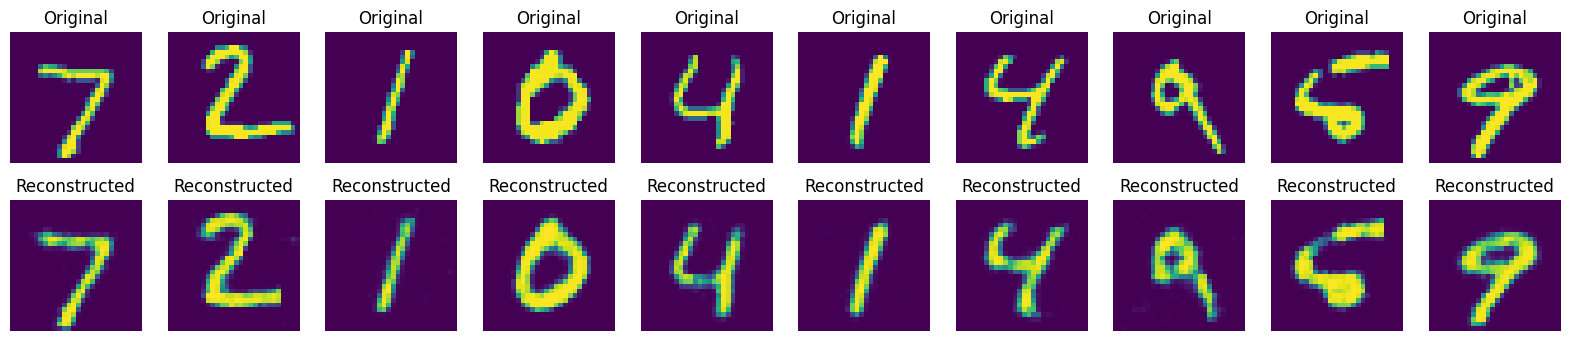

In [ ]:
model.eval()

# Get some test images and their reconstructions
dataiter = iter(test_loader)
images, _ = next(dataiter)
images = images.to(device)
output = model(images)

# Move the images back to CPU for visualization
images = images.cpu().detach().numpy()
output = output.cpu().detach().numpy()

# Visualize the results
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].transpose((1, 2, 0)))
    plt.title("Original")
    plt.axis('off')

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(output[i].transpose((1, 2, 0)))
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

## Compress the images using the encoder and compare the sizes

In [ ]:
def compress(model, test_loader):
    model.eval()
    model.to(device)
    compressed_images, original_images, all_labels = [], [], []
    for images, labels in test_loader:
        images = images.to(device)
        output = model.encoder(images)
        output = model.fc1(output.view(output.size(0), -1))
        original_images.append(images.cpu().detach().numpy())
        compressed_images.append(output.cpu().detach().numpy())
        all_labels.append(labels.cpu().detach().numpy())

    compressed_images = np.array(compressed_images)
    original_images = np.array(original_images)
    all_labels = np.array(all_labels)
    return compressed_images, original_images, all_labels

compressed_images, original_images, all_labels = compress(model, test_loader)

In [ ]:
images.shape, output.shape

((64, 1, 28, 28), (64, 1, 28, 28))

## The compression reduced the size by 95%!

In [ ]:
compressed_size = array_size_mb(compressed_images)
original_size = array_size_mb(original_images)

reduction = original_size - compressed_size
percentage = (reduction / original_size) * 100

percentage

95.02551020408163

## Decompress images using the decoder

In [ ]:
def decompress(model, compressed_images):
    reconstructed_images = []
    for i in range(len(compressed_images)):
        images = compressed_images[i]
        output = model.fc2(torch.tensor(images).to(device))
        output = model.decoder(output.view(output.size(0), 8, 7, 7))
        reconstructed_images.append(output.cpu().detach().numpy())

    reconstructed_images = np.array(reconstructed_images)
    reconstructed_images = reconstructed_images.reshape(-1, 1, 28, 28)
    num_samples = reconstructed_images.shape[0]
    reconstructed_images = reconstructed_images.reshape(num_samples, -1)
    return reconstructed_images

In [ ]:
compression_ratios = [0.5, 0.9, 0.95, 0.99]

In [ ]:
all_original = {}
all_reconstructed = {}
losses= {}
models = {}
for compression_ratio in compression_ratios:
    model, loss = train_model(compression_ratio)
    compressed_images, original_images, all_labels = compress(model, test_loader)
    reconstructed_images = decompress(model, compressed_images)
    all_original[compression_ratio] = original_images
    all_reconstructed[compression_ratio] = reconstructed_images
    losses[compression_ratio] = loss
    models[compression_ratio] = model


100%|██████████| 938/938 [00:05<00:00, 180.98it/s]


Epoch [1/5], Loss: 0.0107


100%|██████████| 938/938 [00:05<00:00, 179.85it/s]


Epoch [2/5], Loss: 0.0066


100%|██████████| 938/938 [00:04<00:00, 193.95it/s]


Epoch [3/5], Loss: 0.0061


100%|██████████| 938/938 [00:04<00:00, 188.79it/s]


Epoch [4/5], Loss: 0.0043


100%|██████████| 938/938 [00:05<00:00, 181.78it/s]


Epoch [5/5], Loss: 0.0053


100%|██████████| 938/938 [00:04<00:00, 196.57it/s]


Epoch [1/5], Loss: 0.0182


100%|██████████| 938/938 [00:04<00:00, 200.68it/s]


Epoch [2/5], Loss: 0.0091


100%|██████████| 938/938 [00:04<00:00, 204.40it/s]


Epoch [3/5], Loss: 0.0075


100%|██████████| 938/938 [00:04<00:00, 203.83it/s]


Epoch [4/5], Loss: 0.0072


100%|██████████| 938/938 [00:04<00:00, 203.08it/s]


Epoch [5/5], Loss: 0.0060


100%|██████████| 938/938 [00:04<00:00, 202.09it/s]


Epoch [1/5], Loss: 0.0165


100%|██████████| 938/938 [00:04<00:00, 203.46it/s]


Epoch [2/5], Loss: 0.0137


100%|██████████| 938/938 [00:04<00:00, 209.72it/s]


Epoch [3/5], Loss: 0.0115


100%|██████████| 938/938 [00:04<00:00, 206.46it/s]


Epoch [4/5], Loss: 0.0080


100%|██████████| 938/938 [00:04<00:00, 206.68it/s]


Epoch [5/5], Loss: 0.0079


100%|██████████| 938/938 [00:04<00:00, 202.72it/s]


Epoch [1/5], Loss: 0.0375


100%|██████████| 938/938 [00:04<00:00, 206.32it/s]


Epoch [2/5], Loss: 0.0330


100%|██████████| 938/938 [00:04<00:00, 206.69it/s]


Epoch [3/5], Loss: 0.0362


100%|██████████| 938/938 [00:04<00:00, 207.93it/s]


Epoch [4/5], Loss: 0.0302


100%|██████████| 938/938 [00:04<00:00, 207.02it/s]


Epoch [5/5], Loss: 0.0286


Fitting TSNE per CR: 4it [01:47, 26.93s/it]


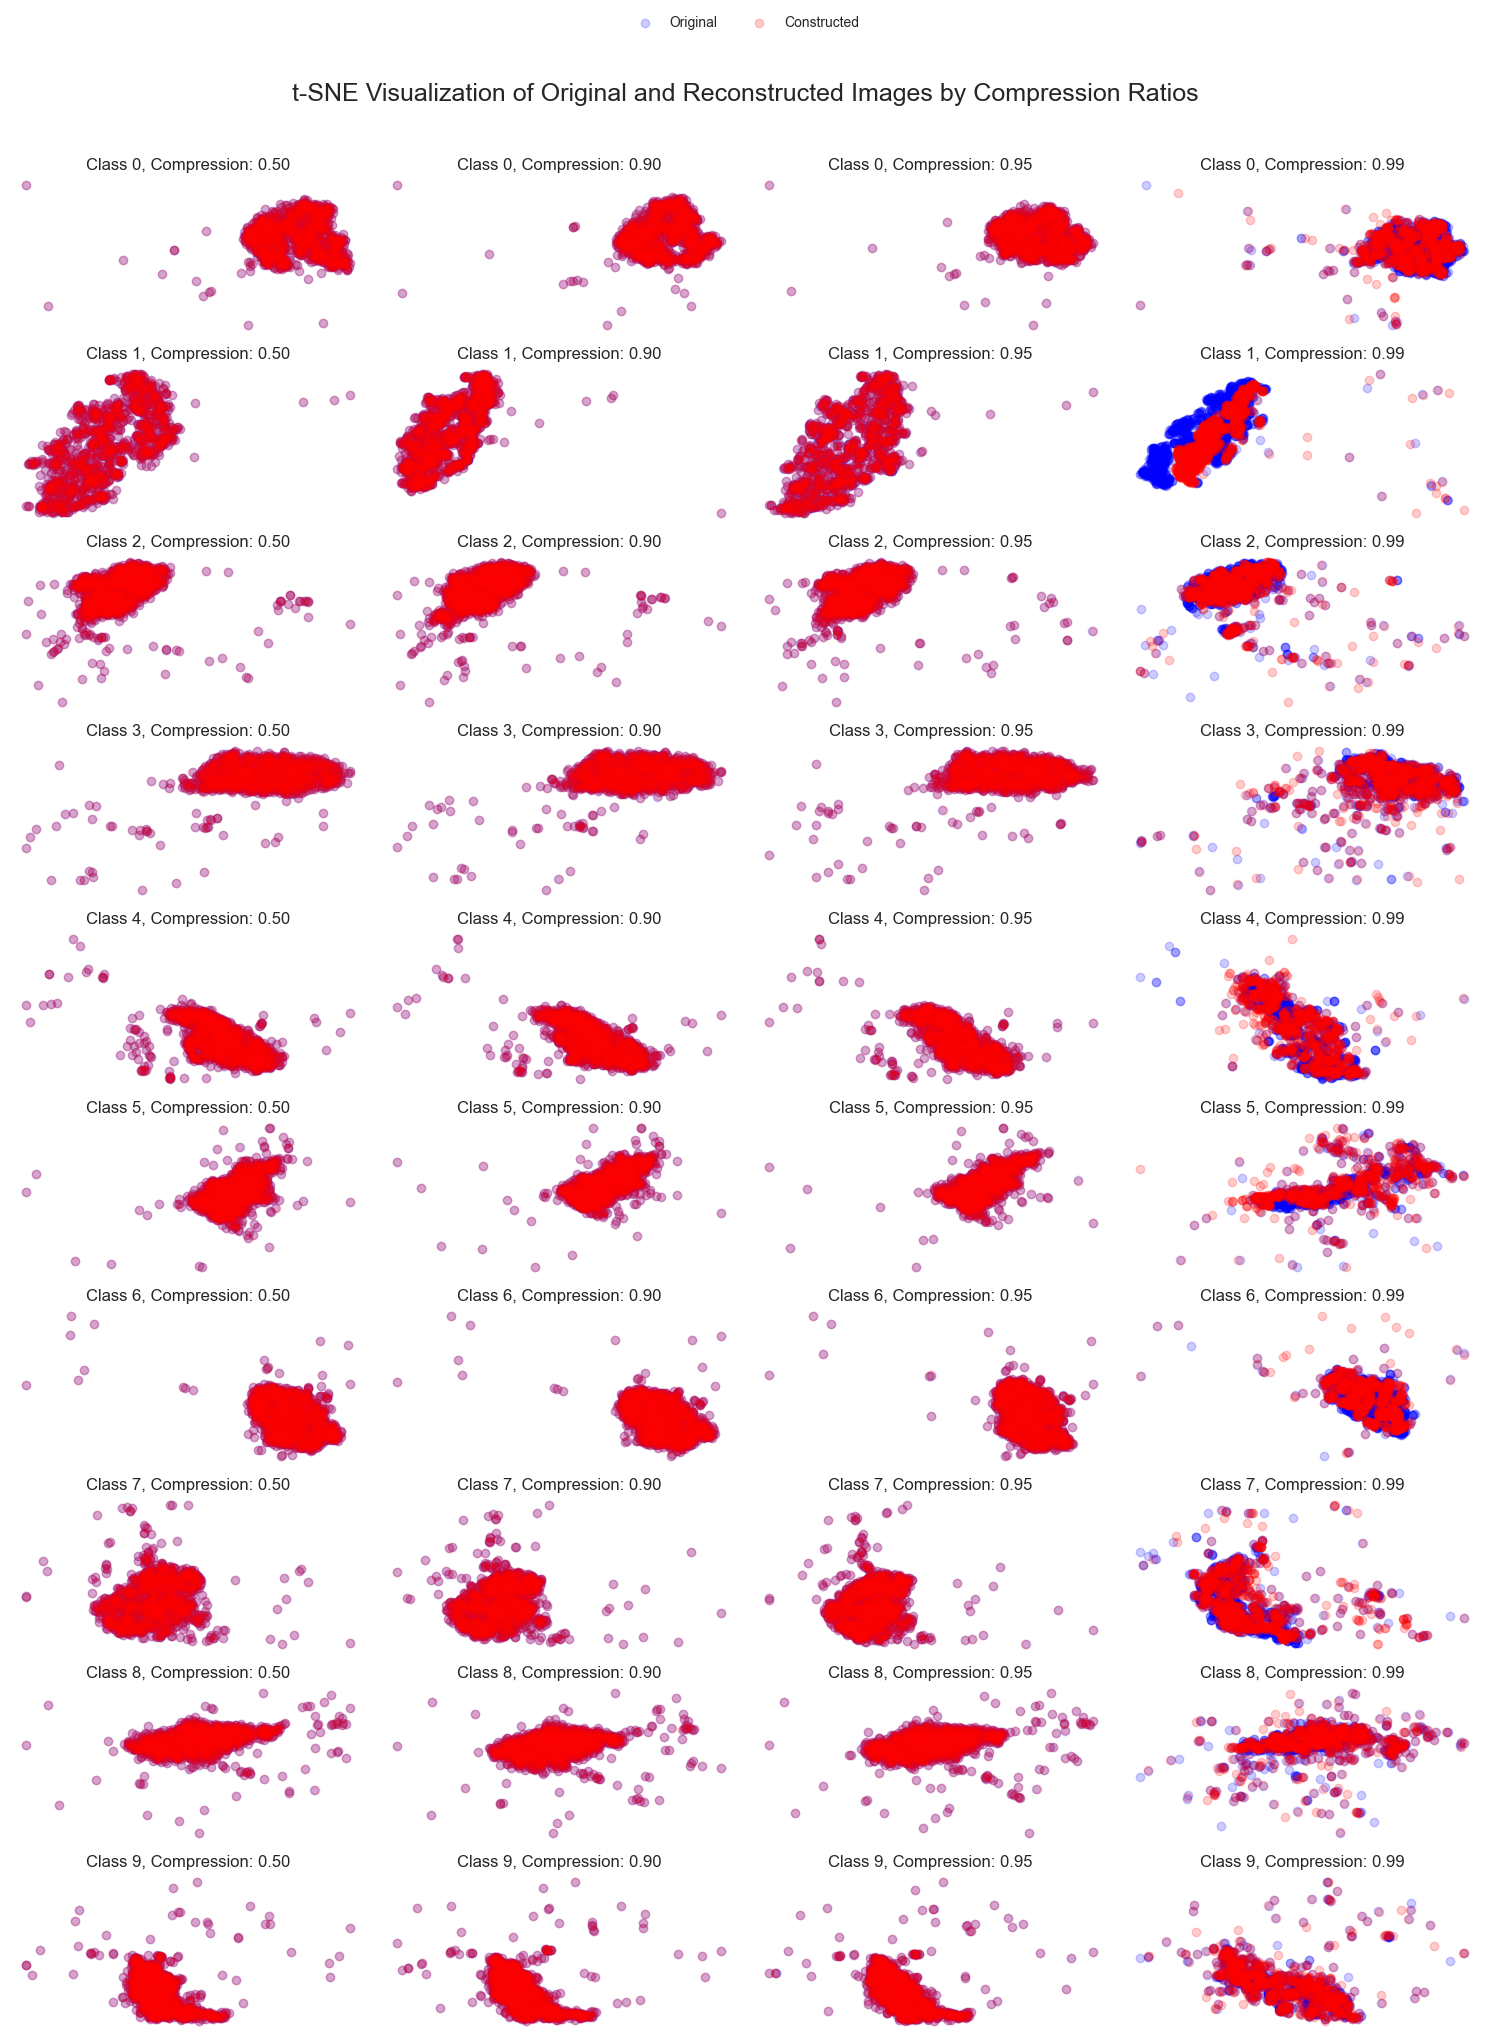

In [ ]:
n_classes = 10

plt.rcParams.update({
    'font.family': 'sans-serif',  # Use a serif font
    'font.serif': ['Helvetica'],  # Specific font
    'axes.labelsize': 12,  # Axis label font size
    'xtick.labelsize': 12,  # X-tick label font size
    'ytick.labelsize': 12,  # Y-tick label font size
    'legend.fontsize': 10,  # Legend font size
})

fig, axes = plt.subplots(nrows=n_classes, ncols=len(compression_ratios), figsize=(15, 20))

for j, cr in tqdm(enumerate(compression_ratios), desc='Fitting TSNE per CR'):
    tsne = TSNE(n_components=2, random_state=0 + j)  # Use different random_state for each CR
    num_samples = all_original[cr].shape[0] * all_original[cr].shape[1]
    original_flat = all_original[cr].reshape(num_samples, -1)
    constructed_flat = all_reconstructed[cr].reshape(num_samples, -1)

    # Fit t-SNE on the combined dataset for each compression ratio
    combined_data = np.vstack((original_flat, constructed_flat))
    combined_tsne = tsne.fit_transform(combined_data)

    # Split the t-SNE results
    midpoint = len(combined_tsne) // 2
    original_tsne = combined_tsne[:midpoint]
    constructed_tsne = combined_tsne[midpoint:]

    for i in range(n_classes):
        idx = all_labels.ravel() == i
        
        # Plotting
        ax = axes[i, j]
        ax.scatter(original_tsne[idx][:, 0], original_tsne[idx][:, 1], c='blue', alpha=0.2, label='Original' if i == 0 and j == 0 else "")
        ax.scatter(constructed_tsne[idx][:, 0], constructed_tsne[idx][:, 1], c='red', alpha=0.2, label='Constructed' if i == 0 and j == 0 else "")
        ax.set_title(f'Class {i}, Compression: {cr:.2f}')
        ax.set_xticks([])
        ax.set_yticks([])

# Set global plot properties and legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=2)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect to make space for the legend above the subplots
fig.suptitle('t-SNE Visualization of Original and Reconstructed Images by Compression Ratios', fontsize=18)
plt.show()

In [ ]:
def plot_all_reconstructed_images(original_images, reconstructed_images, compression_ratios, num_images=5):
    # Determine the total number of rows and columns
    total_rows = num_images  # One row for each set of original and reconstructed images
    total_cols = len(compression_ratios) + 1  # One column for the original image and the rest for reconstructed variations

    # Set up figure size dynamically based on the number of images and rows
    plt.figure(figsize=(3 * total_cols, 2 * total_rows))

    plt.rcParams.update({
    'font.family': 'sans-serif',  # Use a serif font
    'font.serif': ['Helvetica'],  # Specific font
    'grid.color': '#d4d4d4',  # Light gray grid lines
    'axes.edgecolor': '#000000',  # Black edge color for axes
})

    # Plot each set of original and reconstructed images row by row
    for i in range(num_images):
        # Plot the original image first in each row
        ax = plt.subplot(total_rows, total_cols, i * total_cols + 1)
        plt.imshow(original_images[0][i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("Original")

        # Plot each reconstructed image in the subsequent columns of the same row
        for j in range(len(compression_ratios)):
            ax = plt.subplot(total_rows, total_cols, i * total_cols + j + 2)
            plt.imshow(reconstructed_images[j][i].squeeze(), cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title(f"Compression {int(compression_ratios[j]*100)}%")

    plt.suptitle('Original and Reconstructed Images', fontsize=18)
    plt.show()

In [ ]:
# Function to calculate reconstruction error
def calculate_reconstruction_error(model):
    model.eval()
    total_loss = 0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for data in test_loader:
            img, _ = data
            img = img.to(device)
            output = model(img)
            loss = criterion(output, img)
            total_loss += loss.item()
    total_loss /= len(test_loader)
    return total_loss

def calculate_reconstruction_error_by_label(model, label):
    model.eval()
    total_loss = 0
    count = 0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for data in test_loader:
            img, labels = data
            idx = labels == label
            img = img.to(device)
            selected_images = img[idx]
            if selected_images.size(0) == 0:
                continue
            output = model(selected_images)
            loss = criterion(output, selected_images)
            total_loss += loss.item() * selected_images.size(0)
            count += selected_images.size(0)

    total_loss /= count    
    return total_loss

# Function to calculate percentage of compression
def calculate_compression_percentage(latent_dim):
    original_size =  28 * 28  # MNIST image size
    compressed_size = latent_dim
    return 100 * (1 - (compressed_size / original_size))

## Plot the construction error as a function of compression percentage

In [ ]:
# Collect data
compression_percentages = []
reconstruction_errors = []
reconstruction_errors_by_labels = []

latent_dims = [int(28 * 28 * (1 - ratio)) for ratio in compression_ratios]

# Lists to store images for final plot
all_original_images = []
all_reconstructed_images = []

for cr, latent_dim in zip(compression_ratios, latent_dims):
    model = models[cr]
    recon_error = calculate_reconstruction_error(model)
    label_loss = {cr: [calculate_reconstruction_error_by_label(model, label) for label in range(10)]}
    compression_percentage = calculate_compression_percentage(latent_dim)
    
    # Store images for final plot
    original_batch, reconstructed_batch = [], []
    dataiter = iter(test_loader)
    images, _ = next(dataiter)
    images = images[:7].to(device)
    output = model(images)
    
    # Move the images back to CPU for visualization
    original_images = images.cpu().detach().numpy()
    reconstructed_images = output.cpu().detach().numpy()

    all_original_images = [original_images]
    all_reconstructed_images.append(reconstructed_images)
    
    
    compression_percentages.append(compression_percentage)
    reconstruction_errors.append(recon_error)
    reconstruction_errors_by_labels.append(label_loss)
    print(f'Latent Dim: {latent_dim}, Compression: {int(compression_percentage)}%, Reconstruction Error: {recon_error:.4f}')
    

Latent Dim: 392, Compression: 50%, Reconstruction Error: 0.0045
Latent Dim: 78, Compression: 90%, Reconstruction Error: 0.0059
Latent Dim: 39, Compression: 95%, Reconstruction Error: 0.0072
Latent Dim: 7, Compression: 99%, Reconstruction Error: 0.0313


The following plot shows the effect of increasing the compression ration on the reconstructed images
The rows shows the following:
<ul>
<li>The original image</li>
<li>Reconstructed image after 50% compression</li>
<li>Reconstructed image after 90% compression</li>
<li>Reconstructed image after 95% compression</li>
<li>Reconstructed image after 99% compression</li>
</ul>


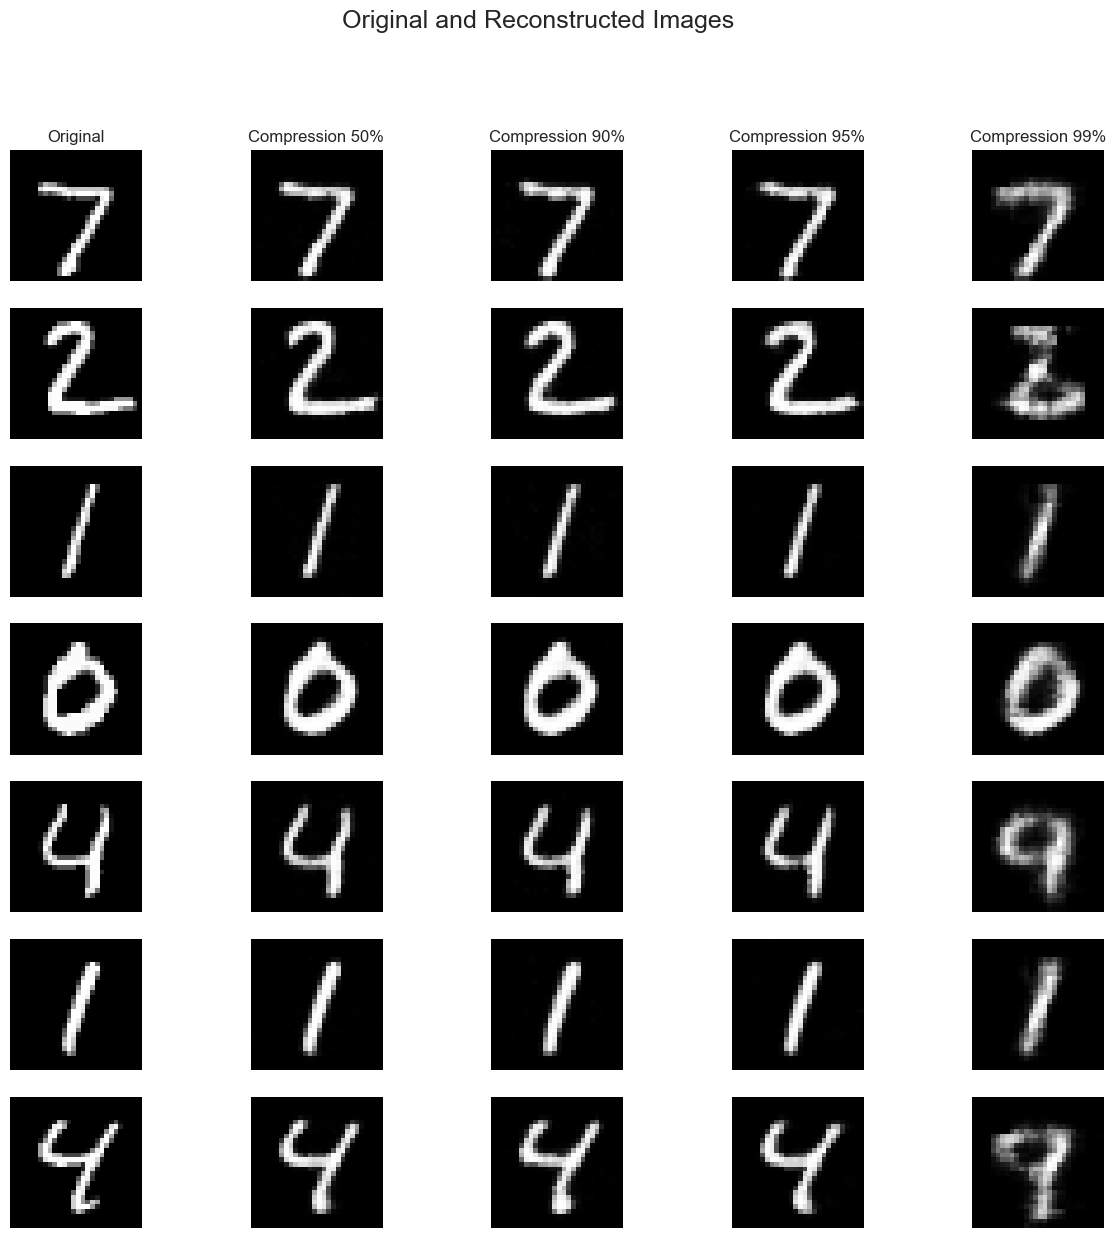

In [ ]:
plot_all_reconstructed_images(all_original_images, all_reconstructed_images, num_images=7, compression_ratios=compression_ratios)

## The error reconstruction error increases with more compression

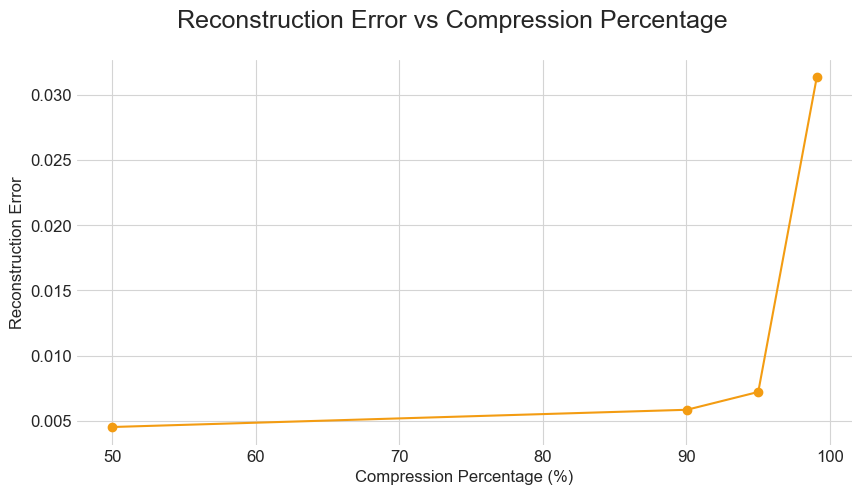

In [ ]:
# Plot the data
plt.figure(figsize=(10, 5))
plt.rcParams.update({
    'font.family': 'sans-serif',  # Use a serif font
    'font.serif': ['Helvetica'],  # Specific font
    'grid.color': '#d4d4d4',  # Light gray grid lines
    'axes.edgecolor': '#000000',  # Black edge color for axes
    'axes.labelsize': 12,  # Axis label font size
    'xtick.labelsize': 12,  # X-tick label font size
    'ytick.labelsize': 12,  # Y-tick label font size
    'legend.fontsize': 10,  # Legend font size
})
plt.plot(compression_percentages, reconstruction_errors, marker='o', color='#F39C12')
plt.suptitle('Reconstruction Error vs Compression Percentage', fontsize=18)
plt.xlabel('Compression Percentage (%)')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()

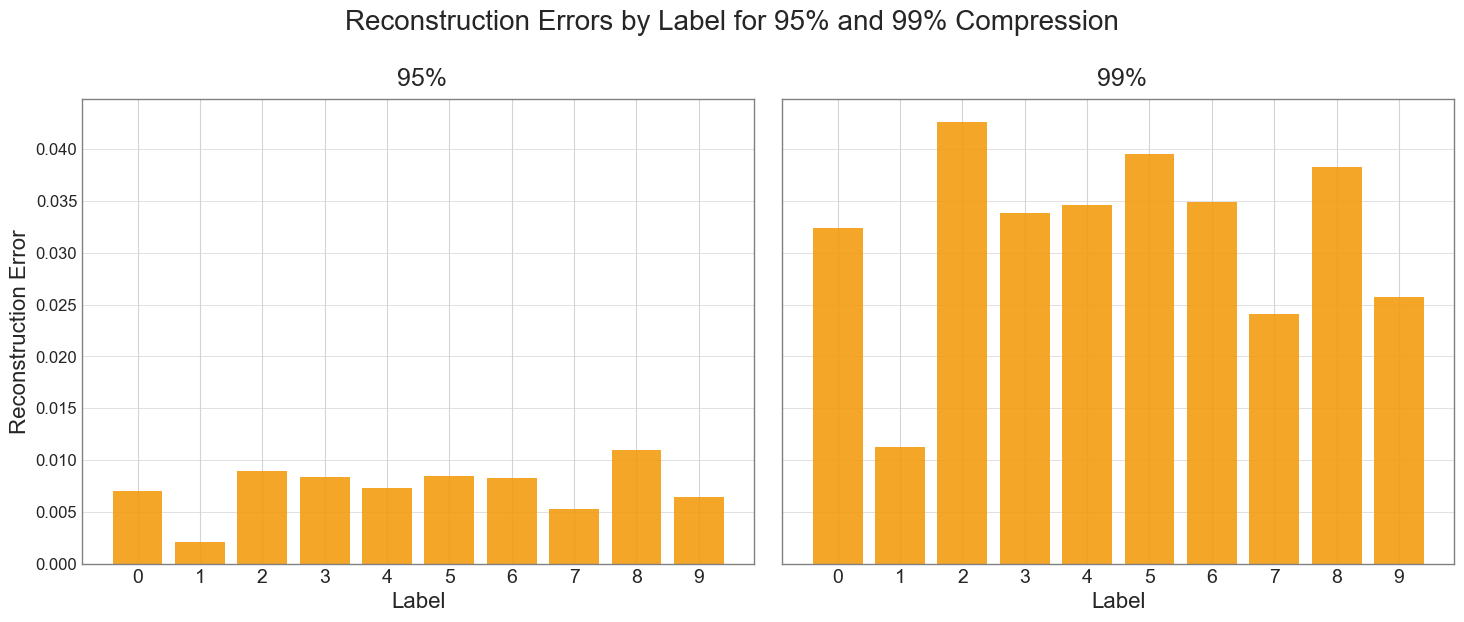

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')  # Base style similar to NYT
plt.rcParams.update({
    'font.family': 'sans-serif',  # Use a serif font
    'font.serif': ['Helvetica'],  # Specific font
    'grid.color': '#d4d4d4',  # Light gray grid lines
    'axes.edgecolor': '#000000',  # Black edge color for axes
    'axes.labelsize': 12,  # Axis label font size
    'xtick.labelsize': 12,  # X-tick label font size
    'ytick.labelsize': 12,  # Y-tick label font size
    'legend.fontsize': 10,  # Legend font size
})

# Create subplots in a single row
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot bar charts of reconstruction errors for each compression ratio
for i, (cr, d) in enumerate(zip(compression_ratios[-2:], reconstruction_errors_by_labels[-2:])):
    errors = [d[cr][label] for label in range(10)]  # Assuming 10 labels
    labels = np.arange(10)  # Labels are integers from 0 to 9
    axes[i].bar(labels, errors, color='#F39C12', alpha=0.9)
    axes[i].set_title(f' {int(100*cr)}%', fontsize=18, pad=10)
    axes[i].set_xlabel('Label', fontsize=16)
    axes[i].set_xticks(labels)
    if i == 0:
        axes[i].set_ylabel('Reconstruction Error', fontsize=16)
    axes[i].tick_params(axis='both', which='both', length=0)
    axes[i].set_xticklabels(axes[i].get_xticks(), fontsize=14)  # Example size, adjust as needed

    axes[i].yaxis.grid(True, which='major', linestyle='-', linewidth=0.5, color='#d4d4d4')
    axes[i].set_axisbelow(True)  # Grid lines below the plot elements

    # Make sure all spines are visible
    for spine in axes[i].spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('grey')
        spine.set_linewidth(1.0)

# Adjust layout to prevent overlap
plt.tight_layout(pad=2)
plt.suptitle('Reconstruction Errors by Label for 95% and 99% Compression', y=1.05, fontsize=20)
plt.show()
